In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import webcolors
import pandas as pd
import cv2
#!pip install webcolors
from tqdm import tqdm
%matplotlib inline



In [2]:
def decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return
    '''
    s = rle_mask.split()
    s = np.asarray(s, dtype= int)
    img = s.reshape(256,256)
    
    return img

In [3]:
df = pd.read_csv('output (8).csv')
decoded_mask = decode(df.loc[3,'PredictionString'])

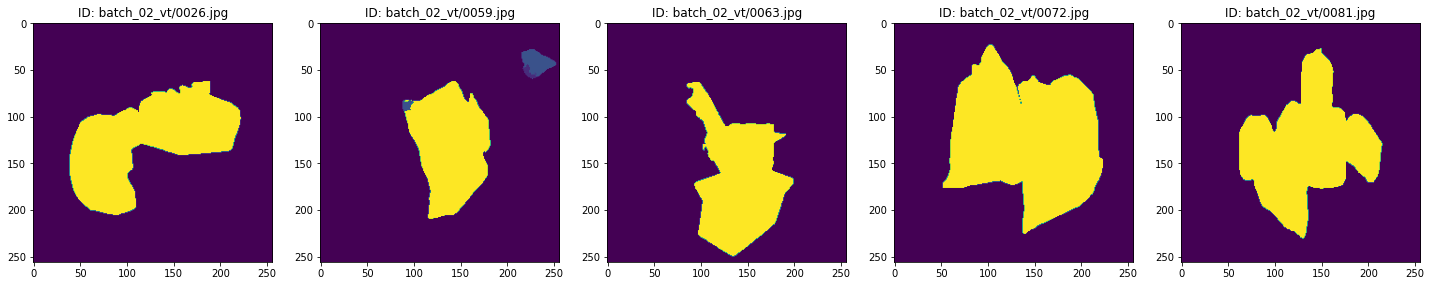

In [4]:
"""
reading and decoding the submission 

"""
df = pd.read_csv('output (8).csv')
i = 527
j = 1
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'image_id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [5]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):

    labels = mask_img.flatten()
    n_labels = 11
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=10, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [6]:
class_colormap = pd.read_csv("class_dict.csv")

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

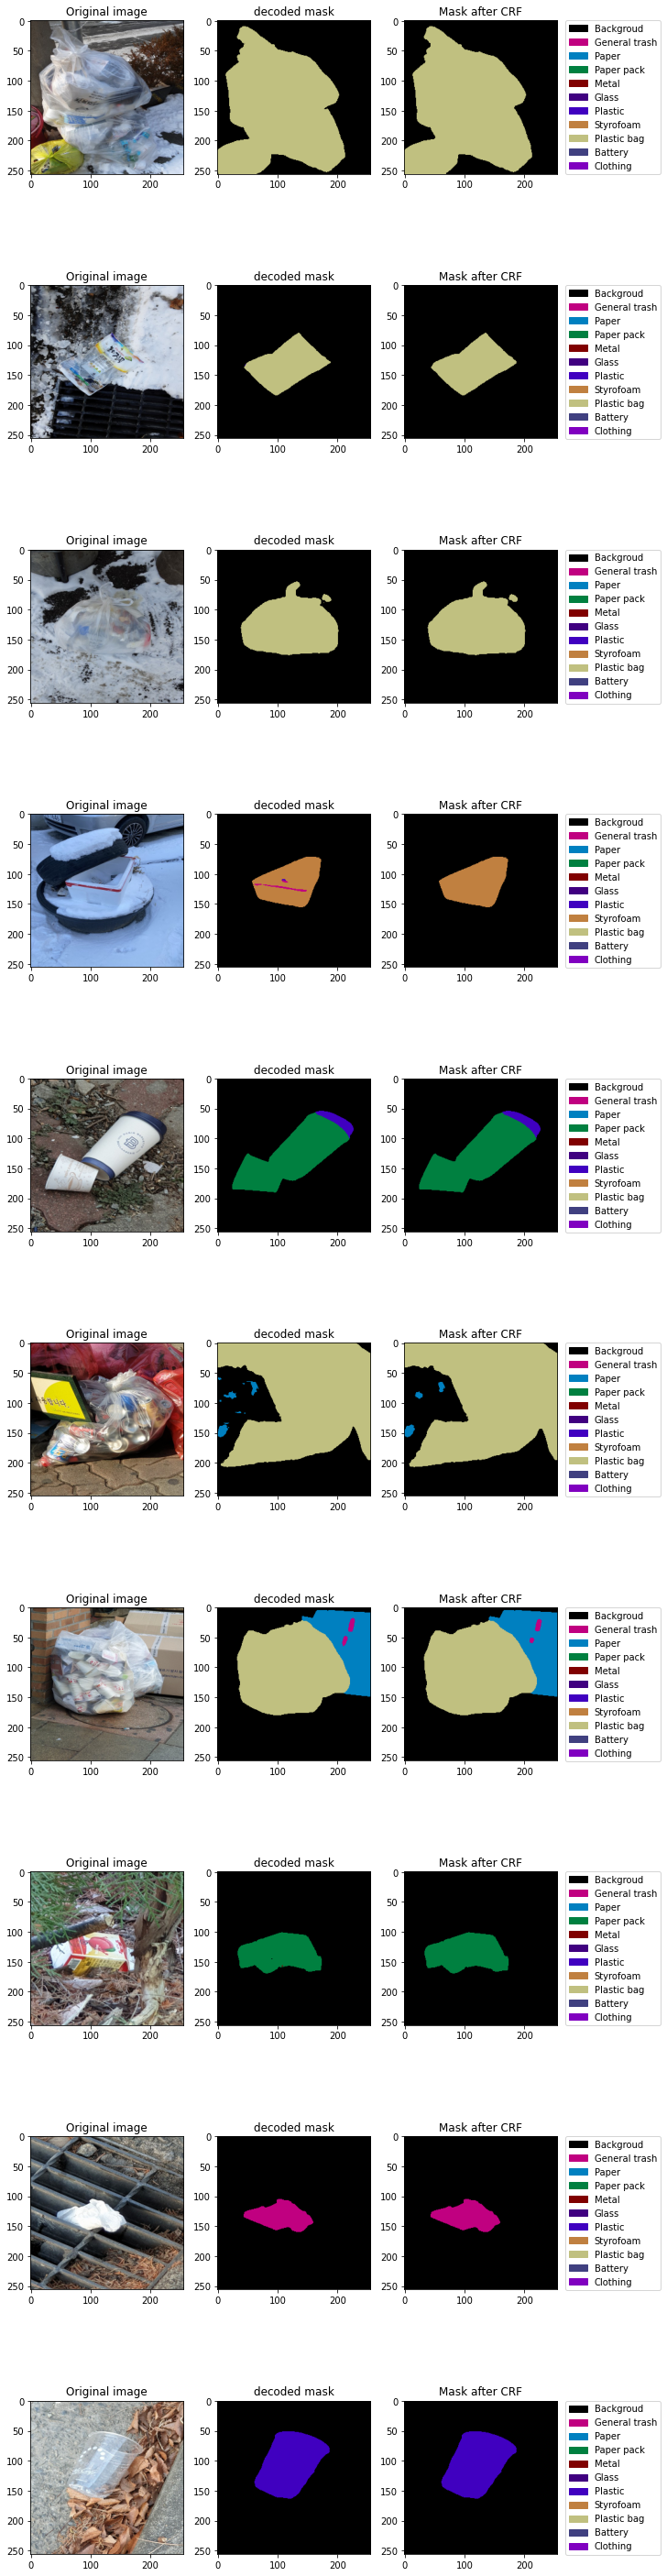

In [7]:
"""
visualizing the effect of applying CRF

"""
test_path = '/opt/ml/input/data/'
nImgs = 10
start = 22

category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                            edgecolor=webcolors.rgb_to_hex(rgb), 
                            label=category) for category, rgb in category_and_rgb]


fig, ax = plt.subplots(nrows=nImgs, ncols=3, figsize=(10, 4*nImgs), constrained_layout=True)
# plt.subplots_adjust(wspace=0.5,hspace=0.5)  #adjust this to change vertical and horiz. spacings..
for i in range(nImgs):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[start + i,'PredictionString'])
        orig_img = cv2.imread(test_path+df.loc[start + i,'image_id'])
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        orig_img = cv2.resize(orig_img, (256,256), interpolation=cv2.INTER_AREA)
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        decoded_mask = label_to_color_image(decoded_mask)
        crf_output = label_to_color_image(crf_output)
  
        
        ax[i][0].imshow(orig_img)
        ax[i][0].set_title('Original image')
        ax[i][1].imshow(decoded_mask)
        ax[i][1].set_title('decoded mask')
        ax[i][2].imshow(crf_output)
        ax[i][2].set_title('Mask after CRF')
        ax[i][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.show()



In [8]:
"""
used for converting the decoded image to rle mask

"""
def encode(im):
    pixels = im.flatten()
    pixels = list(np.asarray(pixels, dtype = str))
    return ' '.join(pixels)

In [9]:
"""
Applying CRF on the predicted mask 

"""
for i in tqdm(range(df.shape[0])):
    if str(df.loc[i,'PredictionString'])!=str(np.nan):        
        decoded_mask = decode(df.loc[i,'PredictionString'])
        orig_img = cv2.imread(test_path+df.loc[i,'image_id'])
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
        orig_img = cv2.resize(orig_img, (256,256), interpolation=cv2.INTER_AREA)      
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'PredictionString'] = encode(crf_output)

100%|██████████| 624/624 [02:15<00:00,  4.59it/s]


In [10]:
df.to_csv('crf_correction.csv',index=False)